✅ Data cleaning complete.
✅ Black-Scholes functions defined.

--- Model Parameters ---
Estimated Nifty50 Spot Price (S): 24600.0
Time to Expiration (T) in years: 0.0001
Assumed Risk-Free Rate (r): 0.07

✅ Black-Scholes prices and errors calculated.


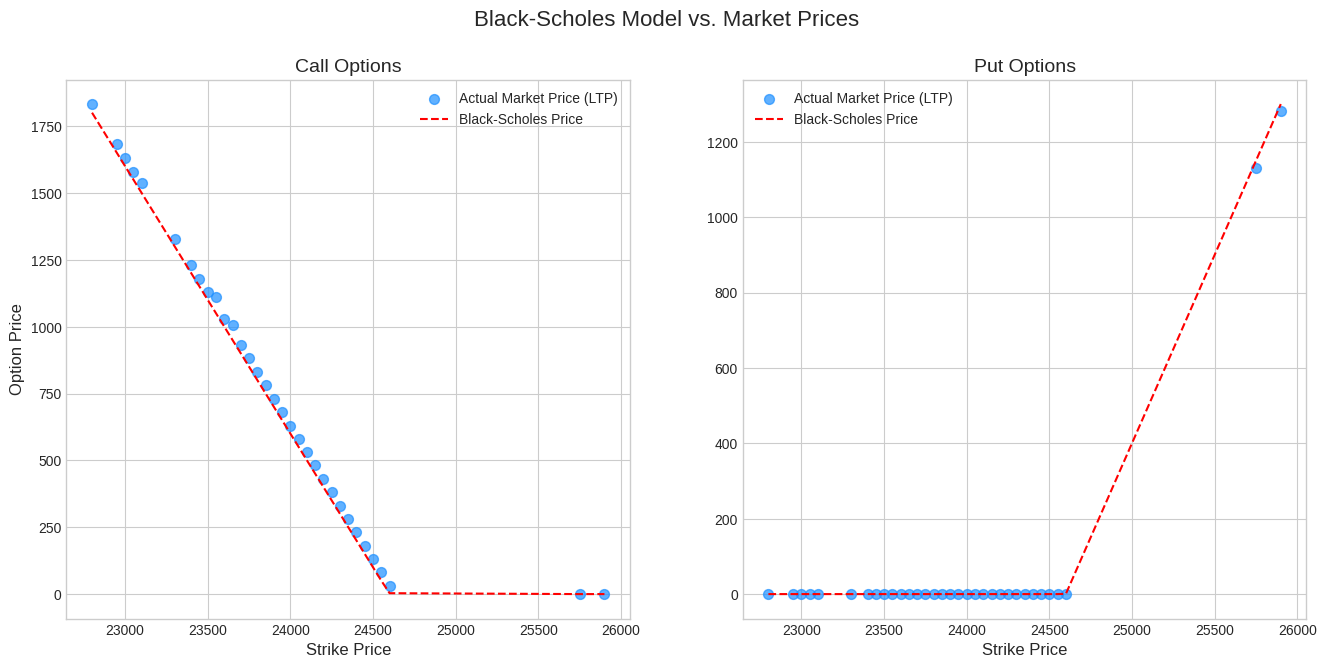

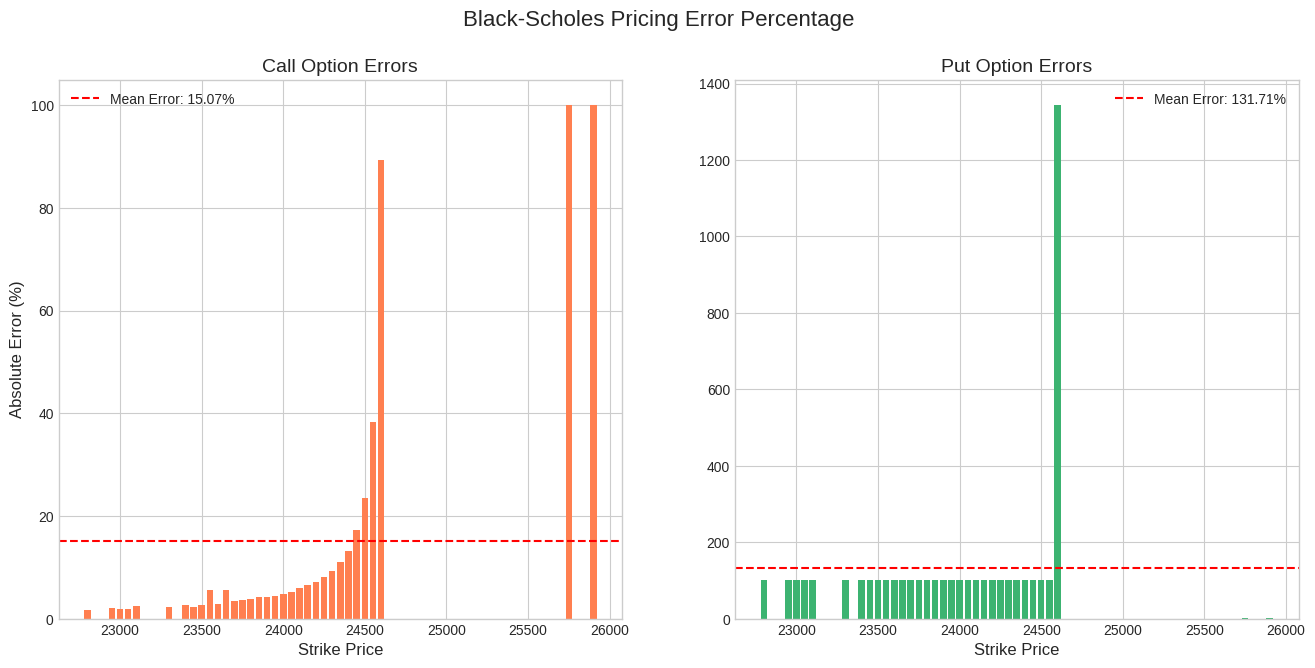


--- Black-Scholes Model Accuracy Summary ---
Mean Absolute Percentage Error (Calls): 15.07%
Mean Absolute Percentage Error (Puts): 131.71%
---------------------------------------------


In [ ]:
# Step 1: Import all the necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt

# --- DATA LOADING AND CLEANING ---

# Step 2: Load the dataset from the uploaded CSV file
# Ensure the filename matches the one you uploaded.
file_path = 'option-chain-ED-NIFTY-14-Aug-2025.csv'
df = pd.read_csv(file_path, header=1) # The actual headers are on the second row

# Step 3: Clean the column names for easier access
df.columns = df.columns.str.strip() # Remove leading/trailing spaces
df.rename(columns={
    'OI': 'CALLS_OI', 'CHNG IN OI': 'CALLS_CHNG_IN_OI', 'VOLUME': 'CALLS_VOLUME',
    'IV': 'CALLS_IV', 'LTP': 'CALLS_LTP', 'CHNG': 'CALLS_CHNG',
    'BID QTY': 'CALLS_BID_QTY', 'BID': 'CALLS_BID', 'ASK': 'CALLS_ASK',
    'ASK QTY': 'CALLS_ASK_QTY', 'STRIKE': 'STRIKE', 'BID QTY.1': 'PUTS_BID_QTY',
    'BID.1': 'PUTS_BID', 'ASK.1': 'PUTS_ASK', 'ASK QTY.1': 'PUTS_ASK_QTY',
    'CHNG.1': 'PUTS_CHNG', 'LTP.1': 'PUTS_LTP', 'IV.1': 'PUTS_IV',
    'VOLUME.1': 'PUTS_VOLUME', 'CHNG IN OI.1': 'PUTS_CHNG_IN_OI', 'OI.1': 'PUTS_OI'
}, inplace=True)

# Step 4: Remove extra rows and columns that are not needed
df = df.iloc[1:] # Remove the repeated header row
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] # Remove empty, unnamed columns
df = df.reset_index(drop=True)

# Step 5: Convert all data columns to a numeric format for calculations
# This loop will replace commas and hyphens, then convert to numbers.
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(',', '').str.replace('-', 'NaN')
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 6: Drop any rows that have missing essential data (like LTP or IV)
df.dropna(subset=['STRIKE', 'CALLS_LTP', 'PUTS_LTP', 'CALLS_IV', 'PUTS_IV'], inplace=True)
df = df.reset_index(drop=True)

print("✅ Data cleaning complete.")

# --- BLACK-SCHOLES MODEL IMPLEMENTATION ---

def black_scholes_call(S, K, T, r, sigma):
    """Calculates the Black-Scholes price for a European call option."""
    if T <= 0 or sigma <= 0:
        return np.maximum(0, S - K)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return price

def black_scholes_put(S, K, T, r, sigma):
    """Calculates the Black-Scholes price for a European put option."""
    if T <= 0 or sigma <= 0:
        return np.maximum(0, K - S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    return price

print("✅ Black-Scholes functions defined.")

# --- PARAMETER SETUP AND CALCULATION ---

# Step 7: Set the parameters for the Black-Scholes model

# 1. Spot Price (S): We estimate this from the data by finding the strike
#    price where the call and put prices are closest (at-the-money).
atm_strike_row = df.loc[(df['CALLS_LTP'] - df['PUTS_LTP']).abs().idxmin()]
S = atm_strike_row['STRIKE']

# 2. Time to Expiration (T): Calculated in years from today to the expiry date.
expiry_date = datetime(2025, 8, 14)
valuation_date = datetime.now()
T = max((expiry_date - valuation_date).days / 365.0, 0.0001) # Use a small positive number if expired

# 3. Risk-Free Interest Rate (r): Assumed to be 7%. You can change this value.
r = 0.07

print("\n--- Model Parameters ---")
print(f"Estimated Nifty50 Spot Price (S): {S}")
print(f"Time to Expiration (T) in years: {T:.4f}")
print(f"Assumed Risk-Free Rate (r): {r}")

# Step 8: Calculate the theoretical price and error for every option
# The Implied Volatility (IV) from the data is used as 'sigma'.
df['BS_CALL_PRICE'] = df.apply(lambda row: black_scholes_call(S, row['STRIKE'], T, r, row['CALLS_IV'] / 100), axis=1)
df['BS_PUT_PRICE'] = df.apply(lambda row: black_scholes_put(S, row['STRIKE'], T, r, row['PUTS_IV'] / 100), axis=1)

df['CALL_PRICE_ERROR_PCT'] = abs((df['BS_CALL_PRICE'] - df['CALLS_LTP']) / df['CALLS_LTP']) * 100
df['PUT_PRICE_ERROR_PCT'] = abs((df['BS_PUT_PRICE'] - df['PUTS_LTP']) / df['PUTS_LTP']) * 100

print("\n✅ Black-Scholes prices and errors calculated.")

# --- VISUALIZATION AND SUMMARY ---

# Step 9: Create and display graphs

# Graph 1: Actual Market Price vs. Black-Scholes Price
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Black-Scholes Model vs. Market Prices', fontsize=16)

# Call Prices Plot
ax1.scatter(df['STRIKE'], df['CALLS_LTP'], label='Actual Market Price (LTP)', color='dodgerblue', alpha=0.7, s=50)
ax1.plot(df['STRIKE'], df['BS_CALL_PRICE'], label='Black-Scholes Price', color='red', linestyle='--')
ax1.set_title('Call Options', fontsize=14)
ax1.set_xlabel('Strike Price', fontsize=12)
ax1.set_ylabel('Option Price', fontsize=12)
ax1.legend()

# Put Prices Plot
ax2.scatter(df['STRIKE'], df['PUTS_LTP'], label='Actual Market Price (LTP)', color='dodgerblue', alpha=0.7, s=50)
ax2.plot(df['STRIKE'], df['BS_PUT_PRICE'], label='Black-Scholes Price', color='red', linestyle='--')
ax2.set_title('Put Options', fontsize=14)
ax2.set_xlabel('Strike Price', fontsize=12)
ax2.legend()
plt.show()


# Graph 2: Pricing Error Percentage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Black-Scholes Pricing Error Percentage', fontsize=16)

# Call Errors Plot
mean_call_error = df['CALL_PRICE_ERROR_PCT'].mean()
ax1.bar(df['STRIKE'], df['CALL_PRICE_ERROR_PCT'], color='coral', width=40)
ax1.axhline(y=mean_call_error, color='r', linestyle='--', label=f"Mean Error: {mean_call_error:.2f}%")
ax1.set_title('Call Option Errors', fontsize=14)
ax1.set_xlabel('Strike Price', fontsize=12)
ax1.set_ylabel('Absolute Error (%)', fontsize=12)
ax1.legend()

# Put Errors Plot
mean_put_error = df['PUT_PRICE_ERROR_PCT'].mean()
ax2.bar(df['STRIKE'], df['PUT_PRICE_ERROR_PCT'], color='mediumseagreen', width=40)
ax2.axhline(y=mean_put_error, color='r', linestyle='--', label=f"Mean Error: {mean_put_error:.2f}%")
ax2.set_title('Put Option Errors', fontsize=14)
ax2.set_xlabel('Strike Price', fontsize=12)
ax2.legend()
plt.show()

# Step 10: Print the final summary of the model's accuracy
mean_abs_pct_error_call = df['CALL_PRICE_ERROR_PCT'].mean()
mean_abs_pct_error_put = df['PUT_PRICE_ERROR_PCT'].mean()

print("\n--- Black-Scholes Model Accuracy Summary ---")
print(f"Mean Absolute Percentage Error (Calls): {mean_abs_pct_error_call:.2f}%")
print(f"Mean Absolute Percentage Error (Puts): {mean_abs_pct_error_put:.2f}%")
print("---------------------------------------------")